In [1]:
""" Script regresses control models against RNN RDM to find best fit"""

' Script regresses control models against RNN RDM to find best fit'

In [2]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
import scipy
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statannot

from cryptic_rnn import *

In [3]:
## functions
def tuple_output(tuple_step, cue_dict):
    out = cue_dict[tuple_step[1]]
    if tuple_step[0]=='-':
        out = -1*out
    return out

#### functions ###################
def control_importance(rdm, val_idx, all_seqs, cuedict, control_mod):

    outs_truth = change_dict(all_seqs, cuedict)
    outs_truth = [t[-1] for t in outs_truth]
    truth_RDM = abs(np.array([outs_truth]*16) - np.array([outs_truth]*16).T)
       
    outs_aug = change_dict(all_seqs, cuedict)
    outs_aug = [tuple_output(t[0], cuedict) for t in outs_aug]
    aug_RDM = abs(np.array([outs_aug]*16) - np.array([outs_aug]*16).T)

    y = []
    x_truth = []
    x_aug = []
    for p in val_idx:
        for q in val_idx:
            y.append(rdm[p,q])
            x_truth.append(truth_RDM[p,q])
            x_aug.append(aug_RDM[p,q])

    y = np.array(y)#.reshape(-1,1)
    x = pd.DataFrame({'ground_truth': np.array(x_truth),
                      'aug_control': np.array(x_aug)})

    if control_mod =='aug':
        lm = ols('y ~ aug_control',x).fit()
        
    elif control_mod == 'ground_truth':
        lm = ols('y ~ ground_truth',x).fit()
    else: 
        lm = ols('y ~ ground_truth + aug_control',x).fit()

    lm.params
    anova_table = anova_lm(lm)
    var_vals = anova_table.loc[:,'sum_sq'] / anova_table['sum_sq'].sum()
    var_exp = np.array(var_vals[:-1])
         
    return var_exp

def get_step_coeffs(RDMs, step_num, control_mod):
    if (control_mod == 'aug') or (control_mod == 'ground_truth'):
        importance_vals = np.empty((0,1))
    else:
        importance_vals = np.empty((0,2))
    for i, rdm_mat in enumerate(RDMs[step_num]):
        imps = control_importance(rdm_mat, val_idx, all_seqs, cue_dicts[i], control_mod)
        importance_vals = np.vstack([importance_vals, imps])
   
    coeff_vals = importance_vals.T.reshape(-1)
    print(len(RDMs[0]))
    N = len(RDMs[0])
    control_mod = ['ground truth']*N + ['augend']*N
    return coeff_vals, control_mod

def all_steps_coeffs(RDM_set, control_mod=None):
    all_coeffs = np.empty((0,1))
    all_controls = []
    step_num = []
    for st in range(4):
        print('step ', st)
        step_coeffs, step_mods = get_step_coeffs(RDM_set,step_num=st,  control_mod=control_mod)
        all_coeffs = np.append(all_coeffs, step_coeffs)
        all_controls += step_mods
        step_num += [st+2]*len(step_mods)
    return pd.DataFrame({'step': step_num, 'variance explained': all_coeffs, 'control':all_controls})

def regress_single_control(rdm_list, cuedict_list, val_idx, all_seqs):
    all_r2s = []
    for i, rdm in enumerate(rdm_list):
        cuedict = cuedict_list[i]
        
        outs_truth = np.linspace(-10, 10 , len(all_seqs))
        truth_RDM = abs(np.array([outs_truth]*16) - np.array([outs_truth]*16).T)

        y = []
        x_truth = []
        for p in val_idx:
            for q in val_idx:
                y.append(rdm[p,q])
                x_truth.append(truth_RDM[p,q])
                
        y = np.array(y)#.reshape(-1,1)
        x = pd.DataFrame({'ground_truth': np.array(x_truth)})

        lm = ols('y ~ ground_truth',x).fit()
        lm.params
        anova_table = anova_lm(lm)
        var_vals = anova_table.loc[:,'sum_sq'] / anova_table['sum_sq'].sum()
        var_exp = np.array(var_vals[:-1])
        all_r2s.append(var_exp[0])
    return all_r2s

In [5]:
# RNN params
num_classes = 22
batchsize=1
hidden_size = 20

rank_dict = {'A': -1.5, 'B': -0.5, 'C':0.5 , 'D':1.5 }
## sequences
ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
input_vals.sort()
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
primitives = generate_pos_primitives(all_syms, cue_dict)

trainseqs = generate_pos_other(ops, all_syms[:-1], cue_dict)
trainseqs_b = generate_pos_other(ops, all_syms[:-1], cue_dict) + generate_balanced_primitives(ops, all_syms, cue_dict)
trainseqs_p = trainseqs + primitives
trainseqs_bp = trainseqs_b + primitives

all_seqs = generate_pos_trials(ops, all_syms, all_syms, cue_dict)
testseqs = [seq for seq in all_seqs if seq not in trainseqs_b]
val_idx = [idx for idx, seq in enumerate(all_seqs) if seq not in trainseqs_b]

## read data 
save_dir = 'Results/4_inputs'
with open(save_dir, 'rb') as f:
    res1 = pickle.load(f)

## 
full_rdmats = calculate_RDMs(res1[1], all_seqs, hidden_size=20)
dms_p = full_rdmats['rdms_p']
dms_b = full_rdmats['rdms_b']
cue_dicts =  full_rdmats['cue_dicts']

# Multiple linear regression

In [6]:
# regress mean RNN RDMs with control RDMs
df_p = all_steps_coeffs(dms_p)
df_b = all_steps_coeffs(dms_b)

step  0
10
step  1
10
step  2
10
step  3
10
step  0
10
step  1
10
step  2
10
step  3
10


In [7]:
# Final step in sequence
N=len(dms_p[0])
dfp4 = df_p[df_p['step']==4].copy()
dfp4['Regime'] = np.repeat(['Primitive'],N*2)
dfb4 = df_b[df_b['step']==4].copy()
dfb4['Regime'] = np.repeat(['Balanced'],N*2)

df4 = pd.concat([dfb4, dfp4])

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  pratt
Balanced_ground truth v.s. Primitive_ground truth: Wilcoxon test (paired samples) with Bonferroni correction, P_val=3.906e-03 stat=0.000e+00
Using zero_method  pratt
Balanced_augend v.s. Primitive_augend: Wilcoxon test (paired samples) with Bonferroni correction, P_val=9.766e-02 stat=8.000e+00


(<Axes: xlabel='Curriculum', ylabel='coefficient of partial determination'>,
  <statannot.StatResult.StatResult at 0x7fd4d14efdc0>])

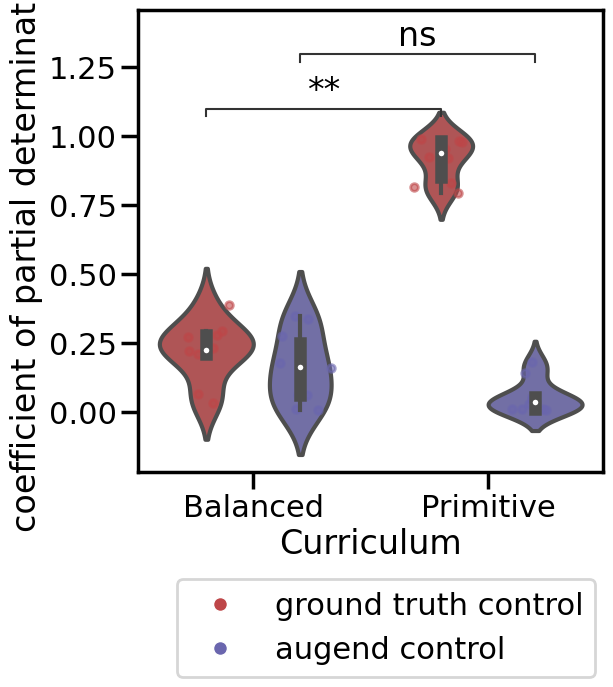

In [8]:
sns.set_context('poster')
colors = ['#BE4648', '#6A66AE']

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[0], markersize=10, label='ground truth control'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[1], markersize=10, label='augend control')]

shift = 0.2
N = len(dms_b[0])
xpos = np.array([[0-shift]*N, [0+shift]*N, [1-shift]*N, [1+shift]*N])
x_jitter = xpos + np.random.normal(0, 0.05, 4*N).reshape(4, N)

y1 = df4[(df4['Regime'] == 'Balanced')&(df4['control'] == 'ground truth')]['variance explained']
y2 = df4[(df4['Regime'] == 'Balanced')&(df4['control'] == 'augend')]['variance explained']
y3 = df4[(df4['Regime'] == 'Primitive')&(df4['control'] == 'ground truth')]['variance explained']
y4 = df4[(df4['Regime'] == 'Primitive')&(df4['control'] == 'augend')]['variance explained']
ys = [y1 , y2, y3, y4]

fig, axs = plt.subplots(figsize= (6,6))
sns.violinplot(data=df4, x = 'Regime', y='variance explained', hue='control', alpha=0.7, palette=colors, capsize=0.04)

for i in range(4):
    axs.scatter(x_jitter[i,:], ys[i], alpha=0.6, color =colors[i%2], s=30)
axs.set_ylabel('coefficient of partial determination')
axs.set_xticks(np.arange(2))
axs.set_xticklabels(['Balanced', 'Primitive'])
axs.set_xlabel('Curriculum')
axs.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=[0.05, -0.2])
#axs.legend(handles=[])

statannot.add_stat_annotation(
    axs,
    data=df4,
    x='Regime',
    y='variance explained',
    hue='control',
    box_pairs=[(('Balanced', 'ground truth'), ('Primitive', 'ground truth')),
               (('Balanced', 'augend'), ('Primitive', 'augend'))],
    test="Wilcoxon",
    text_format="star",
    #loc="outside",
)

#plt.suptitle('Control RDM Multiple Linear \nRegression (time step 4)', y = 1.135)

# Plot RDMs

In [ ]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [ ]:
# plot heatmaps

In [17]:
def flatten_to_strings(listOfLists):
    """Flatten a list of (lists of (lists of strings)) for any level 
    of nesting"""
    result = []

    for i in listOfLists:
        # Only append if i is a basestring (superclass of string)
        if isinstance(i, str):
            result.append(i)
        # Otherwise call this function recursively
        else:
            result.extend(flatten_to_strings(i))
    return result

In [18]:
eq_seq = [seq[:-1] for seq in all_seqs]
seqlabs = [' '.join(list(itertools.chain(*eq_s))) for eq_s in eq_seq]

In [9]:
cuedict = cue_dict
outs_truth = change_dict(all_seqs, cuedict)
outs_truth = [t[-1] for t in outs_truth]
truth_RDM = abs(np.array([outs_truth]*16) - np.array([outs_truth]*16).T)

outs_aug = change_dict(all_seqs, cuedict)
outs_aug = [tuple_output(t[0], cuedict) for t in outs_aug]
aug_RDM = abs(np.array([outs_aug]*16) - np.array([outs_aug]*16).T)


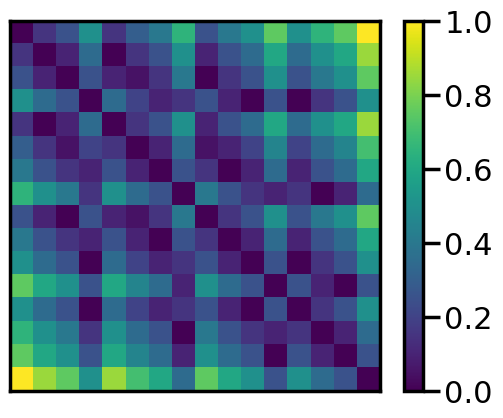

In [10]:
sns.set_context('poster')
fig, ax = plt.subplots()
ax.imshow(truth_RDM)
f = ax.set_xticks([])
f = ax.set_yticks([])
#f = ax.set_xticks(np.arange(16))
#f = ax.set_xticklabels(seqlabs, rotation=60)
#f = ax.set_yticks(np.arange(16))
#f = ax.set_yticklabels(seqlabs, rotation=0)
#plt.suptitle('Ground truth control RDM', y=0.97)
fig.colorbar(cm.ScalarMappable(cmap='viridis'), ax=ax)

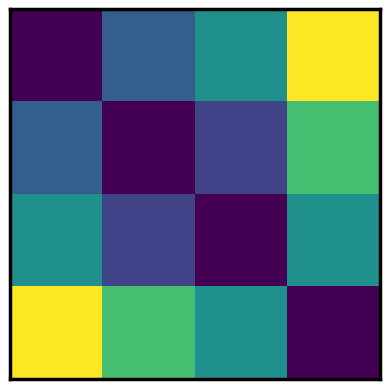

In [12]:
fig, ax = plt.subplots()
ax.imshow(aug_RDM)
f = ax.set_xticks([])
f = ax.set_yticks([])
#f = ax.set_xticks(np.arange(16))
#f = ax.set_xticklabels(seqlabs, rotation=60)
#f = ax.set_yticks(np.arange(16))
#f = ax.set_yticklabels(seqlabs, rotation=0)
#plt.suptitle('Augend control RDM', y=0.97)
#fig.colorbar(cm.ScalarMappable(cmap='viridis'), ax=ax)

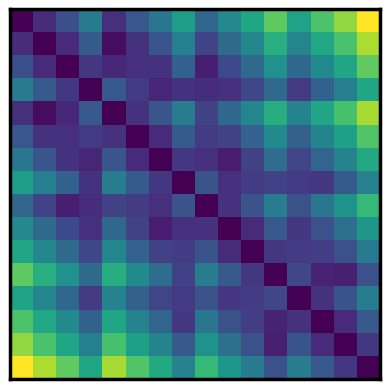

In [13]:
fig, ax = plt.subplots()
ax.imshow(np.array(dms_p[-1]).mean(axis=0))
f = ax.set_xticks([])
f = ax.set_yticks([])
#f = ax.set_xticks(np.arange(16))
#f = ax.set_xticklabels(seqlabs, rotation=60)
#f = ax.set_yticks(np.arange(16))
#f = ax.set_yticklabels(seqlabs, rotation=0)
#plt.suptitle('Primitive regime', y=0.93)


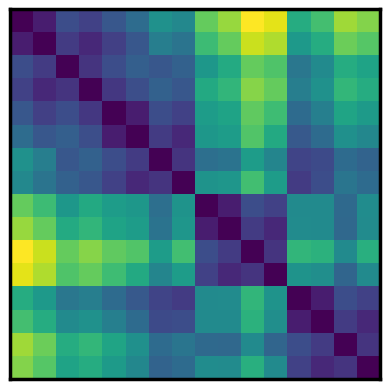

In [14]:
fig, ax = plt.subplots()
ax.imshow(np.array(dms_b[-1]).mean(axis=0))
f = ax.set_xticks([])
f = ax.set_yticks([])
#f = ax.set_xticks(np.arange(16))
#f = ax.set_xticklabels(seqlabs, rotation=60)
#f = ax.set_yticks(np.arange(16))
#f = ax.set_yticklabels(seqlabs, rotation=0)
#plt.suptitle('Balanced regime', y=0.93)
